# HW1 ECE558
==============================================================================

 !! PLEASE READ THESE INSTRUCTIONS BEFORE PROCEEDING !!

In this MP, you will check the approximation errors by Fraunhofer and Fresnel
approximations and will also simulate the wavefront at some distance d from the 
source.

Most of the required code is already set up for you. You may change the code as
much as you want.

P1. Report the approximation errors of Fresnel and Fraunhofer approximations
w.r.t Huygens at distances d = [1e-06, 0.0001, 0.01, 1, 100]. Comment on your 
result.

## Checklist of things to include in the report for the problem:
1) definition of error metric you have chosen and a one-line reason for it.
2) error metric plot for both approximations for distances specified above.
3) Explanation of the error plot (expectations (based on theory) vs results)
4) Any other result you found interesting!

P2. Simulate transmittance through a circular aperture as specified in functions
circ and transmittance. For this you are required to first pass the signal 
through a circ and then immediately pass it through the gaussian transmittance.
Use the Huygens convolution to get the results at different distances d. You can 
choose any distance you want. Choose the sigma of the gaussian to vary between 
1e-3 and 1e-5. Note that the distance is something you supply in problem 2.
If you want to try a range of d, feel free to add a loop.

Please feel free to play with this. Comment on your results. 

[FYI]: I got interesting patterns at d=1e-3 and sigma between 1e-3 and 1e-5.

## Checklist of things to include in the report for the problem:
1) Try at least 3 (distances(d), sigma (sigma)) combinations and show the absolute 
value plot of the signal at these combinations.
2) Explain why such patterns arise (non-rigorous thinking is ok)
3) Any other result you found interesting!


Note: There might still be bugs in the code. Do whatever is necessary to fix them.
I hope the instructions are clearer on what is required. The idea is for you to 
play around with the code and see what's possible and what the wave pattern looks
like.

(Incomplete) CHANGELOG:
 -- Fixed bug in for loop in prob1 - d changed to val
 -- Fixed bug in circ - zero outside circ
 -- circ now also returns the signal
 -- added sigma to transmittance function

In [3]:
%pylab inline
#import numpy as np
#import scipy.signal as sp # used for convolution
#import numpy.linalg as la
#import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [4]:
global LAMBDA
global R
global N

LAMBDA = 4e-7 # wavelength, result required at this wavelength
R = 1e-3 # aperture size, result required at this size
N = 64 # sampling points N*N

In [5]:
## define a meshgrid
def gen_grid(nx, ny):
    """Generate a grid of points in R x R square
    :param nx - number of grid points in x direction
    :param ny - number of grid points in y direction
    
    Returns
    -------
    A nx x ny x 2 grid of coordinates
    """
    x=np.linspace(-R, R, nx)
    y=np.linspace(-R, R, ny)
    xv, yv = np.meshgrid(x,y)
    return np.stack((xv,yv), axis=2)

## define a circular aperture
    # zero out everything not inside the aperture
def circ(s, x, r=1):
    """Define a circular aperture

    :param s - the input signal
    :param x - the grid

    Returns
    -------
    appropriately zeroed signal
    """
    s[la.norm(x, axis=2) > r] = 0
    return s
    
## define a transmittance function for prob 2
def transmittance(s, x, sigma=1e-4):
    """Define a gaussian transmittance function
    :param s - the input signal
    :param x - the grid
    :param sigma - std deviation of the gaussian

    Returns
    -------
    the modified signal
    """
    assert x.shape[:-1] == s.shape, "shape mismatch of signal and grid"

    return s * np.exp(-la.norm(x, axis=2)**2/sigma**2)

def wavefront_after_aperture(s, x):
    """wavefront after the aperture and transmittance filter
    :param s - the input signal
    :param x - the grid
    
    Returns
    --------
    wavefront after passing through aperture with given transmittance
    """
    # you may use the given functions or make your own
    # to implement these
    return transmittance(circ(s, x, R), x)

## define the various filters
def huygens(s,x,d):
    s = sp.convolve2d(s,(-1j*d/LAMBDA)/(d**2+la.norm(x,axis=2)**2)*np.exp(1j*2*np.pi*np.sqrt((la.norm(x,axis=2)**2+d**2)/LAMBDA)),mode='same')
    return s

def fresnel(s,x,d):
    s = np.exp(1j*2*np.pi*d/LAMBDA)*sp.convolve2d(s,np.exp(1j*2*np.pi/LAMBDA*la.norm(x,axis=2)**2/(2*d)),mode='same')
    return s

def fraunhofer(s,x,d):
    s = np.exp(1j*2*np.pi*d/LAMBDA)/(1j*LAMBDA*d)*np.exp(1j*np.pi*(la.norm(x,axis=2)**2)/(LAMBDA*d))*np.fft.fftshift(np.fft.fft2(s))
    return s

## plot their errors
def plot_error(d, err):
    assert len(d)==len(err), "shape mismatch!"
    plt.loglog(d, err)

In [14]:
def prob1():
    # generate a grid of 400 points
    x = gen_grid(N,N) # shape 20 x 20 x 2    
    # create a wavefront at these points
    s = np.ones((N,N))*np.exp(-1j*np.pi/6)   
    # get wavefront afer aperture
    s0 = wavefront_after_aperture(s,x)    
    # get wave solution at different d
    # DO NOT CHANGE THE VALUES OF d in final solution
    d = np.asarray([10**(-6+2*i) for i in range(5)]) #d = [1e-06, 0.0001, 0.01, 1, 100]
    #d = np.asarray([10**(-6+0.2*i) for i in range(50)]) #d = 10times sampling of above d    
    err_fresnel = [] 
    err_fraunhofer = []    

    for val in d:
        s_actual = huygens(s0,x,val)
        s_fresnel = fresnel(s0,x,val)
        s_fraunhofer = fraunhofer(s0,x,val)
        # append errors to the list
        err_fresnel.append(100*sum(sum(abs((s_fresnel-s_actual)/s_actual))))
        err_fraunhofer.append(100*sum(sum(abs((s_fraunhofer-s_actual)/s_actual))))
    
    fig = plt.figure(figsize=[6,4.5],dpi=300)
    plt.xlabel('d/m')
    plt.title('Fresnel vs. Fraunhofer Approximation')
    ax1 = fig.add_subplot(111)  
    l1, = plt.loglog(d, err_fresnel,'ro-',label="Fresnel Approximation Error");  
    ax1.set_ylabel(r'$\Delta$ /%') 
    #ax2 = ax1.twinx() # this is the important function for xyy plot  
    l2, = plt.loglog(d, err_fraunhofer, 'go-',label = "Fraunhofer Approximation Error")   
    plt.legend(handles=[l1, l2], loc='best')    
    return None

In [15]:
def prob2(d):
    """Simulate the wavefront at given distance d"""
    # generate a grid of 400 points
    x = gen_grid(N,N) # shape 20 x 20 x 2    
    # create a wavefront at these points
    s = np.ones((N,N))*np.exp(-1j*np.pi/6)   
    # get wavefront afer aperture
    s0 = wavefront_after_aperture(s,x)
    # std deviation of transmittance filter
    # feel free to play with this
    sigmas = np.logspace(-5, -3, 5) 
    # get wave solution at different d 
    plt.figure(figsize=[6,2],dpi=300)
    i = 0
    for val in sigmas:
        s0 = circ(s0, x)
        # get wavefront afer aperture
        s0 = transmittance(s, x, sigma=val)
        s_actual = huygens(s0, x, d)
        axes = plt.subplot(151+i)
        plt.imshow(np.abs(s_actual))
        axes.set_xticks([])
        axes.set_yticks([])
        plt.title(r'$\sigma$='+str("%.0e"%val))
        plt.suptitle('Wavefront amplitude at distance '+str("%.0e"%d)+'m')
        i += 1
    return None

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


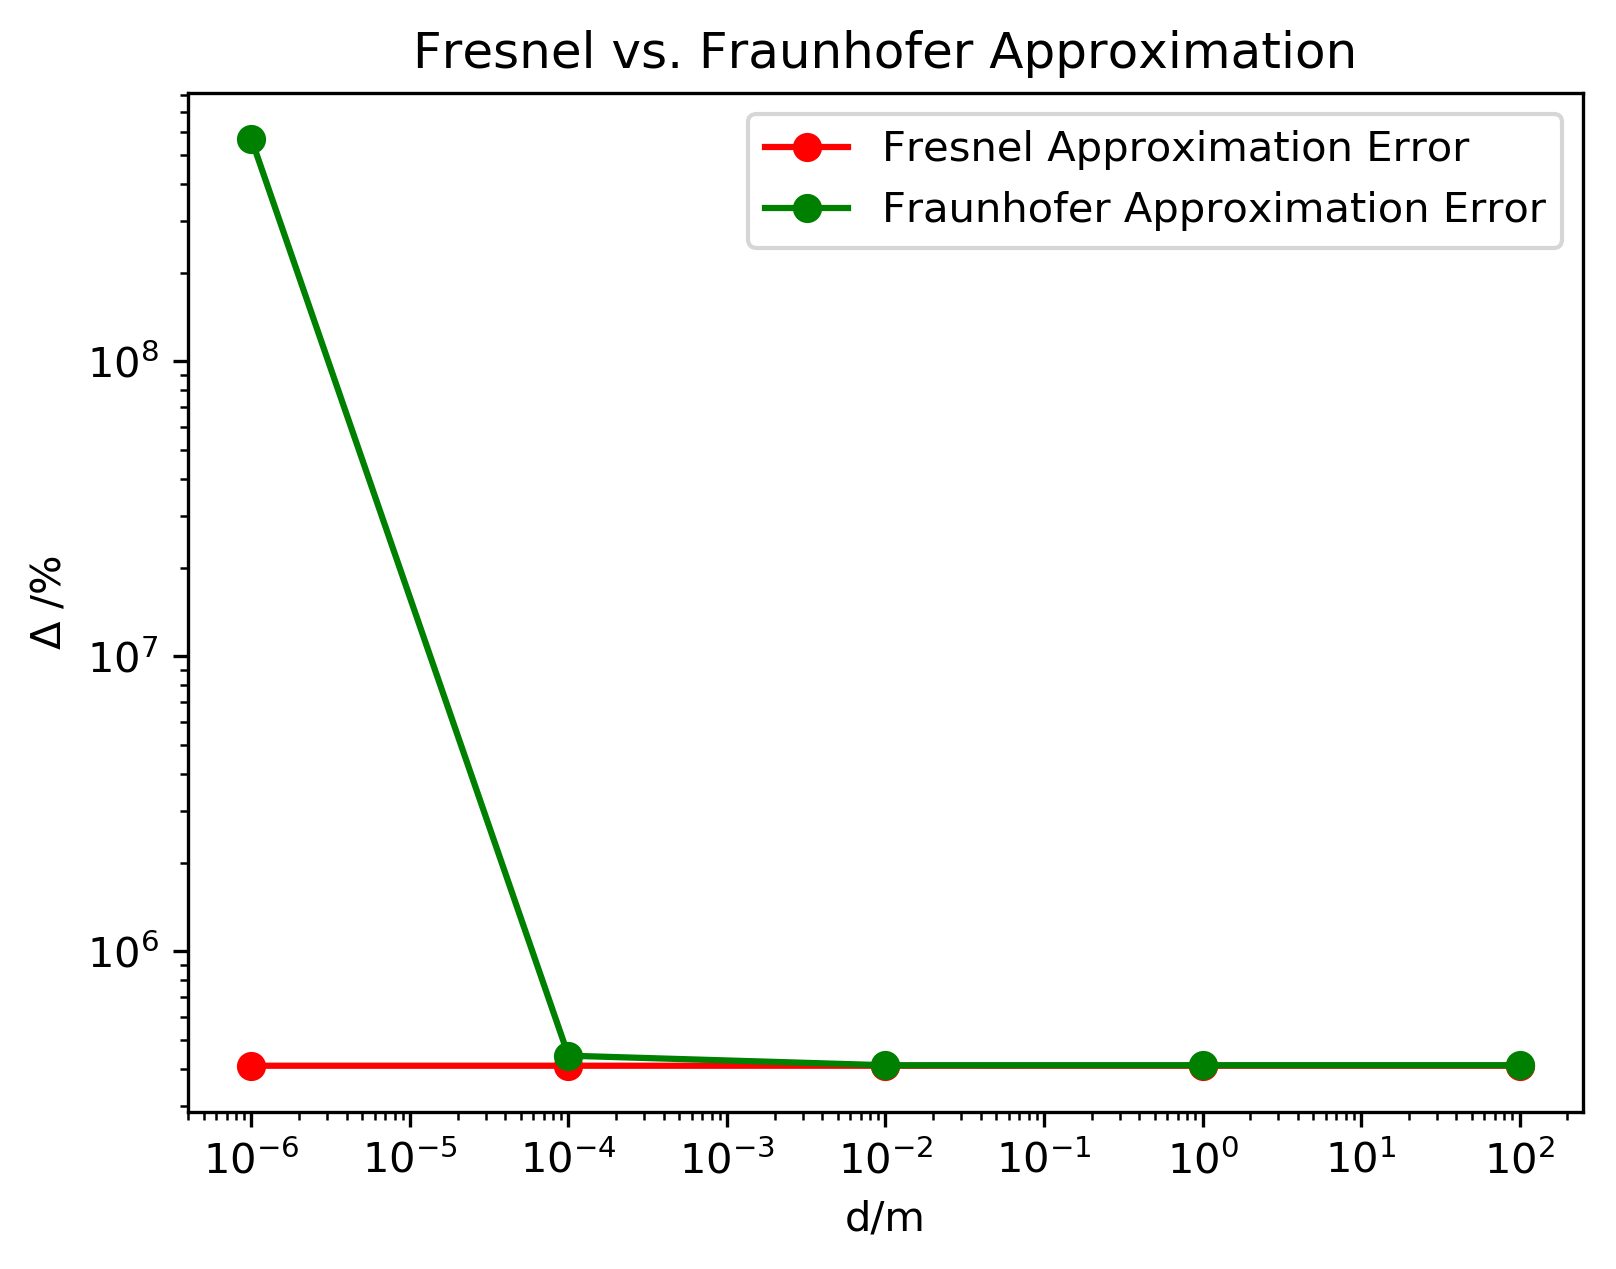

In [13]:
if __name__ == "__main__":
    pass
    prob1()

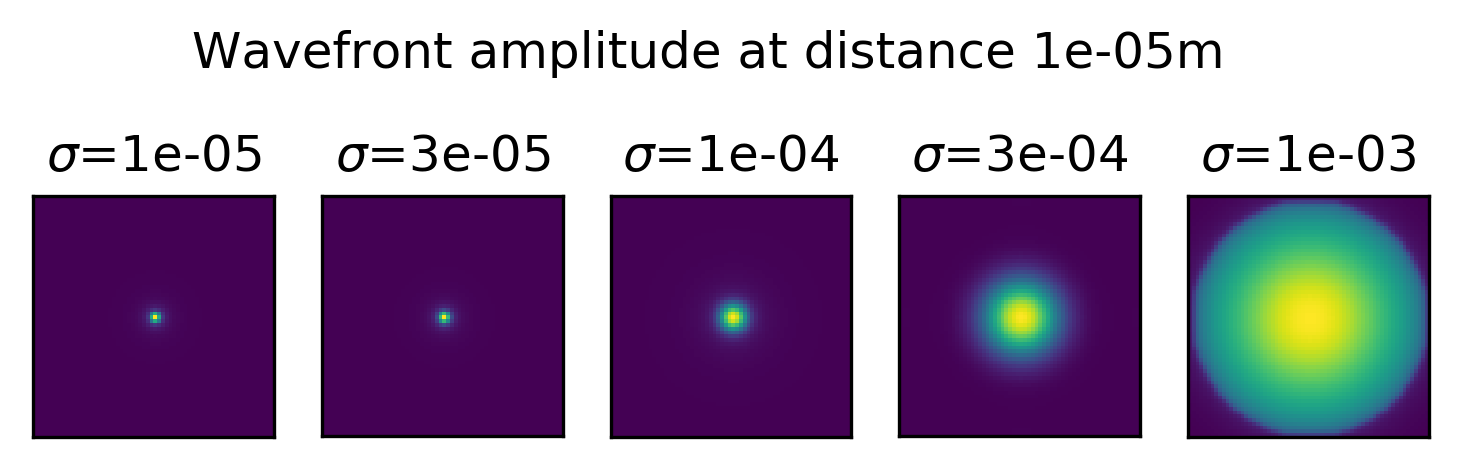

In [10]:
    prob2(1e-5)

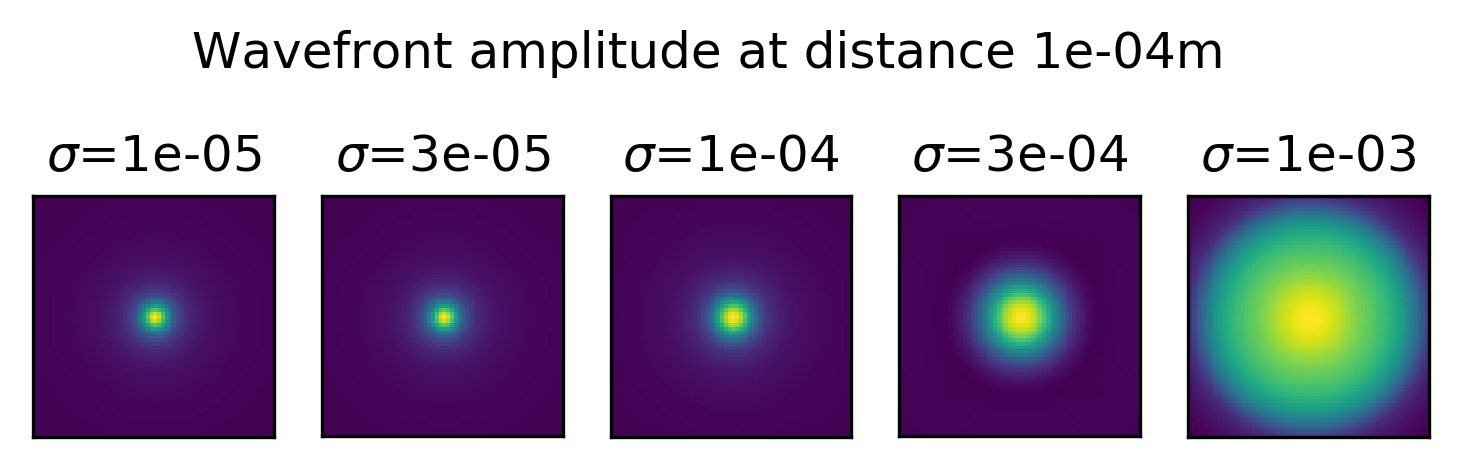

In [11]:
    prob2(1e-4)

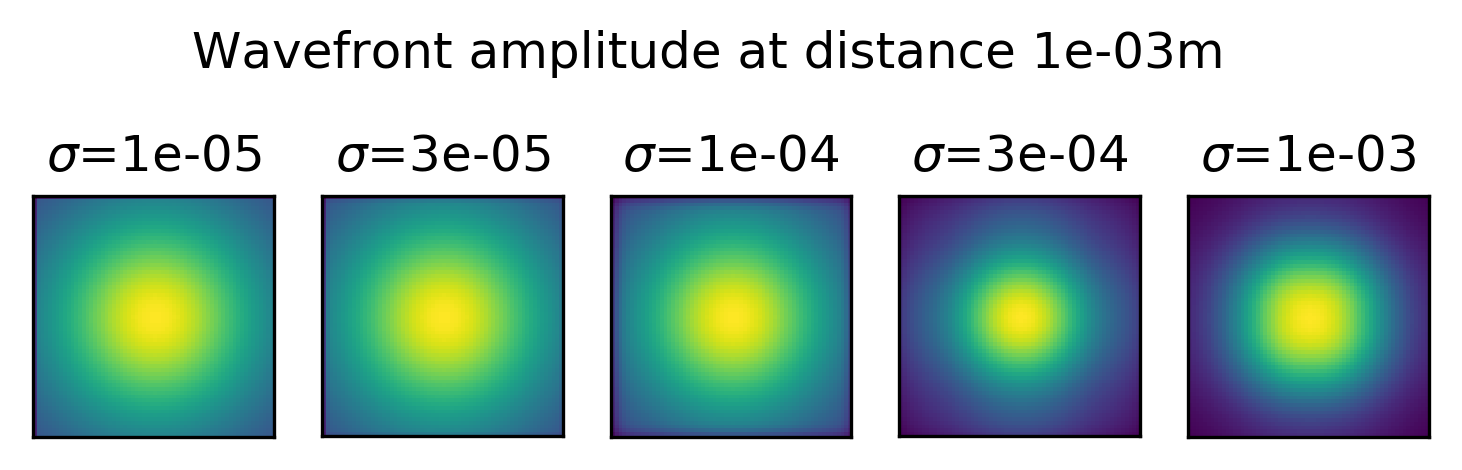

In [12]:
    prob2(1e-3)